In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.25
GAMMA = 0.99
V_MAX = 10
V_MIN = -10
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class CategoricalDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space * n_atoms)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        out = self.fc(out).reshape(out.shape[0], -1, N_ATOMS)
        log_p = self.log_softmax(out)

        return log_p

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()
    
    train_memory = random.sample(rep_memory, BATCH_SIZE)

    dataloader = DataLoader(train_memory,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)

    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s = s.to(device).float()
        a = a.to(device).long()
        _s = _s.to(device).float()
        r = r.to(device).float()
        d = d.to(device).float()
        
        with torch.no_grad():
            _log_p = net(_s)
            _weight = _log_p.exp() * net.support
            _q = _weight.sum(dim=2)
            _a = torch.argmax(_q, dim=1)
            _log_p_tgt = tgt_net(_s)
            _log_p_a = _log_p_tgt[range(BATCH_SIZE), _a]
            _p_a = _log_p_a.exp()
            _p_proj = projection(_p_a, r, d)
        
        log_p = net(s)
        log_p_a = log_p[range(BATCH_SIZE), a]

        # loss
        loss = -(_p_proj * log_p_a).sum(dim=1).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        optimizer.step()


def projection(_p_a, r, d):
    _p_proj = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    r_np = r.cpu().numpy()
    d_np = d.cpu().numpy()
    _p_a_np = _p_a.cpu().numpy()
    batch_id = range(BATCH_SIZE)
    for i in range(N_ATOMS):
        z = np.clip(r_np + GAMMA * (1 - d_np) * (V_MIN + i * DELTA_Z),
                    V_MIN, V_MAX)
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)
        _p_proj[batch_id, l[batch_id]] += d_np + _p_a_np[batch_id, i] * (u - b)[batch_id] * (1 - d_np)
        _p_proj[batch_id, u[batch_id]] += d_np + _p_a_np[batch_id, i] * (b - l)[batch_id] * (1 - d_np)
        
    _p_proj = _p_proj / _p_proj.sum(axis=1, keepdims=1)
    
    return torch.tensor(_p_proj).to(device).float()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p = target_net(state)
        weights = log_p.exp() * net.support
        q = weights.sum(dim=2)
        action = torch.argmax(q, dim=1)

    return action.item()


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(rewards)
    plt.title('Reward')
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

## Main

In [5]:
# make an environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 100000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make a memory
rep_memory = deque(maxlen=memory_size)

# make two nerual networks
net = CategoricalDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=1e-8)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
env.spec.max_episode_steps

200

In [7]:
env.spec.trials

100

In [ ]:
env.spec.reward_threshold

195.0

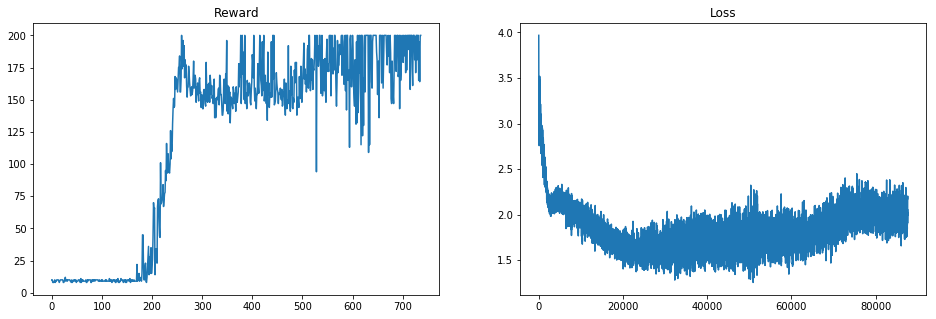

In [ ]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            with torch.no_grad():
                for t, n in zip(target_net.parameters(), net.parameters()):
                    t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
                learn_steps = 0

    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        plot()
#         print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
#             i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_cdqn.pt')
                break
env.close()

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [ ]:
[
    ('CartPole-v0', 215, 0.25),
    ('CartPole-v1', 291, 0.1),
    ('MountainCar-v0', None, 0.1),
    ('LunarLander-v2', None, 0.1)
]